## Denoising and Detoning

### 1. Motivation

공분산 행렬은 금융 어디에서나 존재한다. 경험적 공분산 행렬은 랜덤 벡터를 구성하는 랜덤 변수 사이의 선형 결합을 추정하고자 랜덤 벡터의 일련의 관측값에 대해 계산된다. 이러한 관측값의 유한성과 비결정론적 특성을 고려할 때 공분산 행렬의 추정값에는 일정량의 잡음이 포함되어 있다

금융시장 분석에 있어서 factor들은 이러한 불안정한 공분산으로부터 추정되었기 떄문에 추정된 공분산은 필연적으로 불량 조건 하에 있게 된다. 이 잡음을 처리하지 않는 한 공분산 행렬로 수행하는 계산에 영향을 미칠 수 있으며, 때로는 분석을 무용지물로 만들 수도 있다

이번 장에서는 공분산 행렬에서의 잡음을 줄이고, 경험적 공분산 행렬에 포함된 신호를 개선하도록 한다

### 2. The Marcenko-Pastur Theorem

관측값을 생성하는 기본 프로세스의 평균 0과 분산 $\sigma^2$인 독립적이고 동일하게 분포된 랜덤 관측값 X의 행렬을 고려하자. 행렬 $C = T^{-1}X^\prime X$는 Marcenko-Pastur Probability Density Function으로 점근적으로 수렴하는 고유값을 가진다

$$f(\lambda) = \begin{cases}
\frac{T}{N} \frac{\sqrt{(\lambda_+ - \lambda)(\lambda - \lambda_-)}}{2 \pi \lambda \sigma^2}, & \mbox{     if }\lambda \in [\lambda_-, \lambda_+] \\
0, & \mbox{     if }\lambda \notin [\lambda_-, \lambda_+]
\end{cases}$$

여기서 최대 기대 고유값은 $\lambda_+ = \sigma^2(1 + \sqrt{N/T})^2$이고, 최소 기대 고유값은 $\lambda_- = \sigma^2 (1-\sqrt{N/T})^2$이다. $\sigma^2 = 1$일 때 $C$는 $X$와 연관된 상관 행렬이다. 

아래와 같이 Marcenko-Pastur 분포가 Random Matrix의 고유값을 얼마나 근접하게 설명하는지 보여 준다

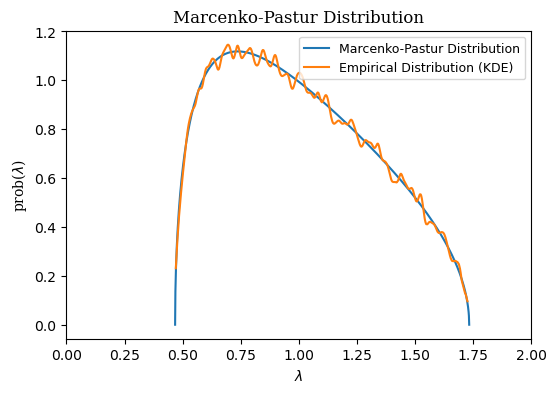

In [1]:
%run MarcenkoPastur.py

#### 3. Random Matrix with Signal

경험적 상관 행렬에서 모든 고유 벡터가 랜덤하지 않을 수 있다 (사실 대부분의 경우에서 고유 벡터는 랜덤하지 않을 것이다)

대부분의 금융시장에서는 신호는 약하고, 잡음은 굉장이 클 것이다. 랜덤 공분산 행렬에 신호를 추가하여 비교해 보자

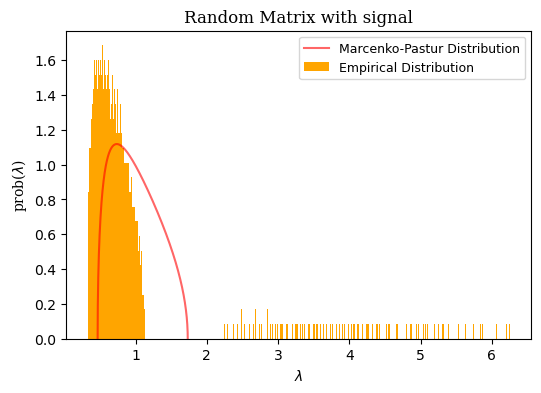

In [2]:
%run RandomMatrixWithSignal.py

고유값이 2가 넘어가는 부분이 signal, 이하 분포는 잡음이다. 랜덤 공분산 행렬에 비해서 분포 자체는 왼쪽으로 치중되어 있고 signal에 대한 고유값은 오른쪽에 분포되어 있다

#### 4. Fitting the Marcenko–Pastur Distribution

분산의 일부만이 랜덤 고유 벡터에 의해 야기되기 때문에 변동성 $\sigma^2$를 $\sigma^2(1 - \lambda_+/N)$등으로 대체할 수 있다. 실제로 $f(\lambda)$라는 함수를 고유값의 경험적 분포에 적합화하여 내재 변동성을 도출할 수 있다

이런 식으로 상관계수 행렬의 랜덤 고유 벡터로 설명되는 분산을 얻을 수 있고, 도출된 분산으로 랜덤이 아닌 고유벡터의 존재를 고려한 significance level $\lambda_+$를 결정할 수 있다

sse:759.4667908862797
sse:759.4666974080013
sse:285.8823584025128
sse:285.88235438625867
sse:277.2989013110133
sse:277.29890561758845
sse:227.61807743714888
sse:227.61808500848696
sse:288.7855472543982
sse:288.7854993590571
sse:53.1632357529847
sse:53.16324687899641
sse:18.850551841489416
sse:18.85055440945854
sse:40274.102885418804
sse:40274.0967916495
sse:506.92882690218744
sse:506.9287571397072
sse:17.908365491926403
sse:17.908365827047852
sse:17.893078376461418
sse:17.89307835816469
sse:17.893033082948712
sse:17.893033083068637
sse:17.89303308106135
sse:17.89303308106149
found errPDFs0.6797265955944773


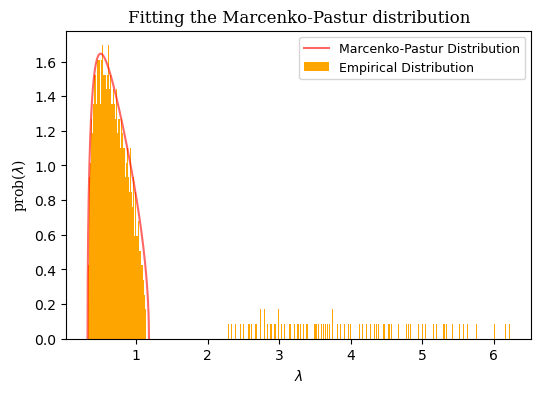

In [3]:
%run FittingMarcenkoPastur.py

적합화된 분산의 약 32.32%만이 신호에서 기인함을 볼 수 있으며, 이 절차를 통해 잡음과 관련된 고유값을 신호와 관련된 고유값에서 분리할 수 있었다

#### 5. Denoising

empirical finance에서 대부분의 경우 공분산을 축소하여 사용하는 것이 일반적이다. 그러나 차원의 축소는 잡음 뿐만 아니라 신호 또한 구분하지 않고 조건의 수를 감소시킨다. 안그래도 약한 신호를 축소를 통해 더욱 약하게 만들 수도 있다

이번 절에서는 상관 행렬의 잡음 제거에 이 정보를 사용하는 방법에 대해 논한다

**5.1 Constant Residual Eigenvalue Method**

이 접근 방식은 모든 랜덤 고유 벡터에 대해 상수 고유값을 설정하는데에 있다. $\{\lambda_n\}_{n=1, \dots, N}$은 모든 고유값의 집합이며, 내림차순이며, $i$는 $\lambda_i > \lambda_+$와 $\lambda_{i+1} \leq \lambda_+$가 되는 고유값의 위치가 된다. 그런 다음 $\lambda_j = frac{1}{N-i} \sum_{k = i+1}^N \lambda_k, j = i+1, \dots, N$을 설정해 상관 행렬의 대각합을 보존한다. 고유 벡터 분해 $VW = W\Lambda$가 주어질 때 다음과 같이 잡음이 제거된 상관행렬 $C_1$을 형성한다

$$\tilde C_1 = W \tilde\Lambda W^\prime$$
$$C_1 = \tilde C_1\Big[ \big(\mbox{diag}[\tilde C_1]\big)^\frac{1}{2}
\big(\mbox{diag}[\tilde C_1]\big)^{\frac{1}{2} \prime}\Big]^{-1}$$

sse:747.1191707245201
sse:747.119078538451
sse:285.1893203540755
sse:285.1893159578173
sse:274.94211000020556
sse:274.94211468106295
sse:218.3399731316133
sse:218.33998114402635
sse:559.986915009485
sse:559.9868379591728
sse:72.3310067546569
sse:72.33101874347774
sse:18.028431254605856
sse:18.028433083603304
sse:1234.08994720713
sse:1234.0898058462756
sse:17.56165092063975
sse:17.561650646256354
sse:17.55164199147652
sse:17.551642003782852
sse:17.551621646341403
sse:17.551621646418518
sse:17.551621645581097
sse:17.5516216455812
found errPDFs0.6781433279982108


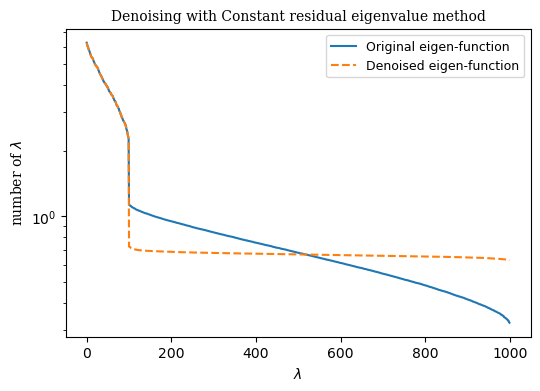

In [8]:
%run ConstantResidual.py

**5.2 Targeted Shrinkage**

5.1에서 설명한 수치적 방법은 신호를 보존하면서 잡음을 제거하기 때문에 축소보다는 선호된다. 대안적으로 랜덤 고유 벡터에 대해 엄격한 축소 적용을 목표로 할 수도 있다. 다음의 상관 행렬 $C_1$을 고려하자

$$C_1 = W_L\Lambda_L W_L^\prime + \alpha W_R \Lambda_R W_R^\prime + (1-\alpha) \mbox{diag}
[W_R \Lambda_R W_R^\prime]$$

여기서 $W_R$과 $\Lambda_R$은 $\{n|\lambda_n \leq \lambda_+\}$와 관련된 고유 벡터와 고유값이고, $W_L$과 $\Lambda_L$은 $\{n|\lambda_n > \lambda_+\}$와 관련된 고유 벡터와 고유값이며, $\alpha$는 잡음과 관련된 고유 벡터와 고유값 사이의 축소량을 조절한다

sse:750.8545105177766
sse:750.8544158555289
sse:288.60151398172445
sse:288.60151001399794
sse:279.94286800270163
sse:279.9428726559035
sse:229.96200670637484
sse:229.9620140380727
sse:235.78428966326894
sse:235.78424654476987
sse:42.76195446490793
sse:42.7619646021645
sse:18.76000851382263
sse:18.760010641457942
sse:5239.227115563017
sse:5239.226594155041
sse:61.08752896155852
sse:61.087509708276876
sse:18.12770277432154
sse:18.12770313374422
sse:18.110148620209216
sse:18.110148602734842
sse:18.11010745576276
sse:18.110107455893917
sse:18.11010745351104
sse:18.110107453511013
found errPDFs0.6775278481884519


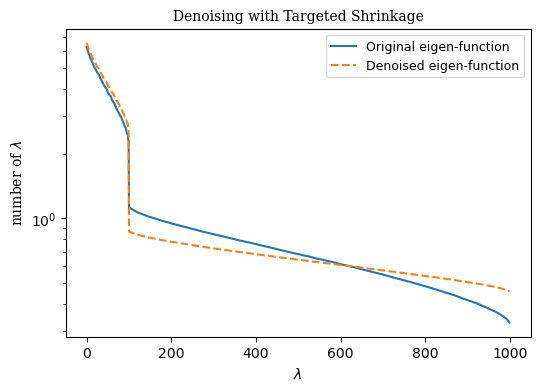

In [5]:
%run TargetedShrinkage.py

#### 6. Detoning

금융 상관 행렬은 일반적으로 시장 요소를 포함한다. 시장 구성 요소는 로딩 $W_{n,1} \approx N^{\frac{1}{2}}, n=1,\dots, N$를 가진 첫 번째 고유 벡터로 특징된다. 따라서 시장 요소는 공분산 행렬의 모든 항목에 영향을 미친다

군집화 알고리즘 응용의 맥락에서 경우 시장 요소는 제거하는 것이 유용하다. 알고리즘이 군집 간 차이를 찾고자할 것이므로, 강력한 시장 구성 요소를 가진 상관 행렬을 군집화하는 것이 더 어렵기 때문이다

시장 요소를 제거하여 그 상관관계의 더 많은 부분을 유가증권의 특정 부분집합에 영향을미치는 요소들에 의해 설명될 수 있도록 한다. 잡음이 제거된 상관행렬 $C_1$에서 시장 요소를 제거해 주음 제거된 상관 행렬을 형성할 수 있다

$$\tilde C_2 = C_1 - W_M \Lambda_M W_M^\prime = W_D \Lambda_D W_D^\prime$$
$$C_2 = \tilde C_2\Big[ \big(\mbox{diag}[\tilde C_2]\big)^\frac{1}{2}
\big(\mbox{diag}[\tilde C_2]\big)^{\frac{1}{2} \prime}\Big]^{-1}$$

여기서 $W_M$과 $\Lambda_M$은 시장 요소와 관련된 고유 벡터 및 고유값이고, $W_D$와 $W\Lambda_D$는 비시장 요소와 관련된 고유 벡터 및 고유값이다. 주음 제거된 상관 행렬은 최소 1개의 고유 벡터를 제거한 결과로 특이 행렬이다

평균-분산 포트폴리오 최적화에 주음이 제거된 상관 행렬 $C_2$는 직접 사용할 수 없다. 대신에 선택된 주성분을 기반으로 포트폴리오를 최적화하고, 최적 배분 $f^*$를 원래 기저로 매핑할 수 있다. 원래 기저에서의 최적 배분은 다음과 같다

$$\omega ^* = W_+f^*$$

여기서 $W_+$는 주음 제거 프로세스에서 살아남은 고유 벡터만을 포함하며, $f^*$는 동일한 성분에 대한 최적 배분 벡터이다

sse:750.0035867306946
sse:750.0034925511974
sse:288.6965080992569
sse:288.696504248607
sse:280.50472095594995
sse:280.50472547174996
sse:231.6384944037434
sse:231.63850211720427
sse:195.71241074975256
sse:195.71237181927893
sse:187.6982004178371
sse:187.6982097318883
sse:19.58298952335003
sse:19.58299284329387
sse:7036642712506.261
sse:7022590508897.954
sse:1227.142483197762
sse:1227.1423466633405
sse:17.956652587888712
sse:17.956652556987528
sse:288.6965080992569
sse:288.696504248607
sse:17.95694095131345
sse:17.956941006994043
sse:17.95652462316867
sse:17.9565246231712
sse:17.956524623169095
sse:17.956524623169084
sse:17.956524623168562
sse:17.95652462317058
found errPDFs0.678024276431493


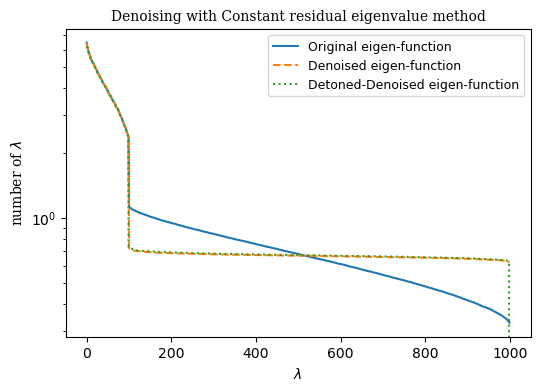

In [7]:
%run Detoning.py

#### 7. Experimental Results

잡음이 제거된 공분산 행렬로 작업하면 상당한 편익을 얻을 수 있다. 이러한 편익은 처리된 행렬의 수학적 특성에서 비롯되며, Montecarlo simulation을 통해 평가할 수 있다

**7.1 Minimum Variance Protfolio**

잡음 제거된 것과 제거가 되지 않은 최소 분산 포트폴리오의 추정과 관련된 오류를 계산한다.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from RandomMatrixWithSignal import cov2corr, getRndCov
from MarcenkoPastur import getPCA
from FittingMarcenkoPastur import findMaxEval
from ConstantResidual import denoisedCorr2, denoisedCorr

def formBlockMatrix(nBlocks,bSize,bCorr): 
    block=np.ones((bSize,bSize))*bCorr 
    block[range(bSize),range(bSize)]=1 
    corr = block_diag(*([block]*nBlocks)) 
    return corr
def formTrueMatrix(nBlocks,bSize,bCorr):
    corr0 = formBlockMatrix(nBlocks,bSize,bCorr)
    corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols) 
    corr0=corr0[cols].loc[cols].copy(deep=True) 
    std0=np.random.uniform(.05,.2,corr0.shape[0]) 
    cov0=corr2cov(corr0,std0) 
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1) 
    return mu0,cov0

from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf 
nBlocks,bSize,bCorr=10,50,.5
np.random.seed(42)
mu0,cov0 = formTrueMatrix(nBlocks,bSize,bCorr)

<Axes: >

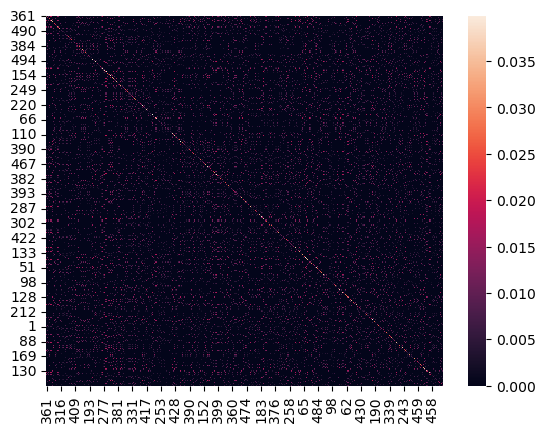

In [18]:
import seaborn as sns

sns.heatmap(cov0)

이는 효율적인 시장에서 모든 증권들이 동일한 기대 샤프 비율을 갖고 있다는 개념과 일치한다

아래 예제는 비경험적 공분산 행렬을 사용하여 $T \times N$크기의 랜덤 행렬 $X$를 추출하고, 관련 경험적 공분산 행렬과 평균 벡터를 도출한다. 함수 `simCovMu()`는 T값을 설정하는 인수 nObs를 받는다

In [19]:
def simCovMu(mu0,cov0,nObs,shrink=False): 
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs) 
    mu1 = x.mean(axis=0).reshape(-1,1)
    if shrink: cov1=LedoitWolf().fit(x).covariance_ 
    else: cov1=np.cov(x,rowvar=0)
    return mu1,cov1
def corr2cov(corr,std): 
    cov=corr*np.outer(std,std) 
    return cov
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0) 
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth) 
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0) 
    corr1=denoisedCorr(eVal0,eVec0,nFacts0) 
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1

In [21]:
nObs = 5
mu1, cov1 = simCovMu(mu0, cov0, nObs)

<Axes: >

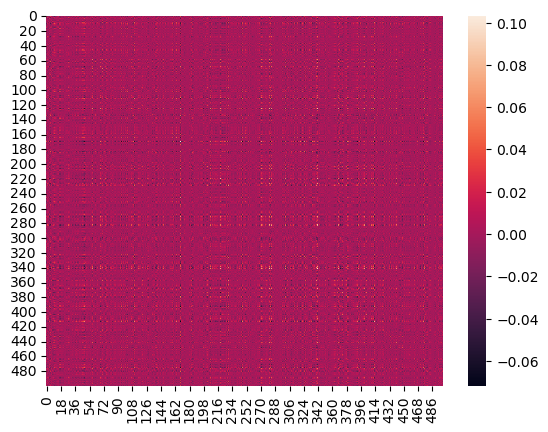

In [22]:
sns.heatmap(cov1)

parameter `shrink = True`일 때 이 기능은 경험적 공분산 행렬의 Ledoit-Wolf 축소를 수행한다

<Axes: >

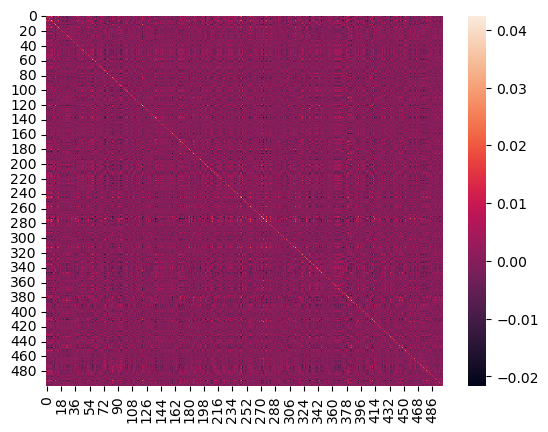

In [23]:
mu2, cov2 = simCovMu(mu0, cov0, nObs, shrink=True)
sns.heatmap(cov2) # Ledoit-Wolf shrinkage

아래의 예제를 통해 MonteCarlo Experiment을 진행한다. 아래와 같은 사항을 따른다
1. T=1000으로 랜덤 empirical covairance matrix를 추출한다
2. empirical covariance의 잡음을 제거한다
3. `optPort()`함수를 통해 최소 분산 포트폴리오를 도출한다

In [26]:
def optPort(cov,mu=None): 
    inv=np.linalg.inv(cov) 
    ones=np.ones(shape=(inv.shape[0],1)) 
    if mu is None:mu=ones
    w=np.dot(inv,mu) 
    w/=np.dot(ones.T,w) 
    return w

nObs,nTrials,bWidth,shrink,minVarPortf=1000,1000,.01,False,True 
w1=pd.DataFrame(columns=range(cov0.shape[0]), index=range(nTrials),dtype=float) 
w1_d=w1.copy(deep=True)
np.random.seed(42)
for i in range(nTrials):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None 
    cov1_d=deNoiseCov(cov1,nObs*1./cov1.shape[1],bWidth) 
    w1.loc[i]=optPort(cov1,mu1).flatten() 
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()

sse:2.6584240061138855
sse:2.6584237641402426
sse:65.86261707972844
sse:65.86261668573232
sse:3.0175636900833402
sse:3.0175643219616473
sse:2.6128343466852617
sse:2.6128343484665804
sse:2.6128317015095583
sse:2.612831701600983
sse:2.612831694569371
sse:2.612831694569337
found errPDFs0.50383662994183
sse:3.523566341304655
sse:3.5235656689962127
sse:65.0009489823954
sse:65.0009486052578
sse:4.876843534577168
sse:4.876844649433018
sse:3.171961199877157
sse:3.1719612111496387
sse:3.171844191802962
sse:3.1718441932290364
sse:3.1718422947484317
sse:3.171842294744991
sse:3.1718422947356215
sse:3.1718422947356215
found errPDFs0.5109589336735239
sse:2.9545704595130986
sse:2.9545697949424197
sse:63.57220380315404
sse:63.57220341300838
sse:4.238834429552602
sse:4.238835560283349
sse:2.535928478935393
sse:2.5359284525890295
sse:2.5354149218486466
sse:2.535414926962971
sse:2.5353944711900187
sse:2.535394471242625
sse:2.535394469057577
sse:2.5353944690574686
found errPDFs0.5121964670609257
sse:3.790

KeyboardInterrupt: 